# Prediction of the energy with Coulomb matrices avec invariance par rotation

In [2]:
# !pip install ase
# !pip install dscribe
from ase.build import molecule
from dscribe.descriptors import CoulombMatrix
from ase.io import read
import os
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import os
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

In [3]:
path_to_test = '../data/atoms/test'
path_to_train = '../data/atoms/train'

In [4]:
# Read all the atoms files in the test directory
test_files = [os.path.join(path_to_test, f) for f in os.listdir(path_to_test) if f.endswith('.xyz')]
# Read all the atoms files in the train directory
train_files = [os.path.join(path_to_train, f) for f in os.listdir(path_to_train) if f.endswith('.xyz')]
# Read the atoms objects
test_atoms = [read(f) for f in test_files]
train_atoms = [read(f) for f in train_files]
# Create a DataFrame for test atoms
test_df = pd.DataFrame({
    'file': test_files,
    'atoms': test_atoms
})
# Create a DataFrame for train atoms
train_df = pd.DataFrame({
    'file': train_files,
    'atoms': train_atoms
})

In [6]:
# Compute the Coulomb matrix for each atom in the test set
# Avec "eigenspectrum" --> 
def compute_coulomb_matrix_rotation(atoms, nb_max):
    cm = CoulombMatrix(
        n_atoms_max=nb_max,
        permutation="none",
    )
    # Créer la matrice de Coulomb de taille nb_max x nb_max
    matrix = cm.create(atoms, n_jobs=-1).reshape((nb_max, nb_max))
    # Calculate the eigenvalues and sort them
    _, eigenvectors = np.linalg.eig(matrix)
    matrix_cos = np.zeros((nb_max, nb_max))
    for i in range(nb_max):
        for j in range(nb_max):
            matrix_cos[i, j] = np.dot(eigenvectors[:, i], eigenvectors[:, j])
    return matrix_cos

# Get the maximum number of atoms in the test set
nb_max = max(len(atoms) for atoms in test_atoms + train_atoms)

# Apply the function to compute Coulomb matrices for test atoms
test_df['coulomb_matrix'] = test_df['atoms'].apply(compute_coulomb_matrix_rotation, nb_max=nb_max)
# Apply the function to compute Coulomb matrices for train atoms
train_df['coulomb_matrix'] = train_df['atoms'].apply(compute_coulomb_matrix_rotation, nb_max=nb_max)
# Save the DataFrames to CSV files
test_df.to_csv('../data/atoms/test_coulomb_matrices.csv', index=False)
train_df.to_csv('../data/atoms/train_coulomb_matrices.csv', index=False)
# Print the first few rows of the test DataFrame
print(test_df.head())
# Print the first few rows of the train DataFrame
print(train_df.head())

                             file  \
0  ../data/atoms/test/id_7475.xyz   
1  ../data/atoms/test/id_8126.xyz   
2  ../data/atoms/test/id_6986.xyz   
3  ../data/atoms/test/id_7252.xyz   
4  ../data/atoms/test/id_7830.xyz   

                                               atoms  \
0  (Atom('C', [1.361622, 2.59097, 1.656713], inde...   
1  (Atom('C', [-1.401807, 1.300455, 1.370504], in...   
2  (Atom('N', [-1.899187, -0.508295, 0.543062], i...   
3  (Atom('C', [-0.839082, -0.01128, 2.179564], in...   
4  (Atom('C', [1.228525, 0.356839, -1.70174], ind...   

                                      coulomb_matrix  
0  [[1.0, -7.632783294297951e-17, -2.775557561562...  
1  [[1.0000000000000004, -1.1102230246251565e-16,...  
2  [[1.0, 1.1102230246251565e-16, -5.551115123125...  
3  [[0.9999999999999998, -2.7755575615628914e-17,...  
4  [[0.9999999999999999, -1.6653345369377348e-16,...  
                              file  \
0   ../data/atoms/train/id_438.xyz   
1  ../data/atoms/train/id_4184.xyz

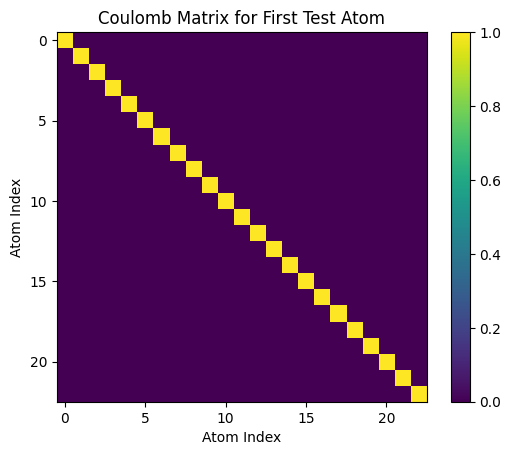

In [7]:
# Afficher une matrice de Coulomb pour un atome de test
import matplotlib.pyplot as plt
def plot_coulomb_matrix(matrix, title='Coulomb Matrix'):
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Atom Index')
    plt.ylabel('Atom Index')
    plt.show()
# Plot the Coulomb matrix for the first test atom
plot_coulomb_matrix(test_df['coulomb_matrix'].iloc[0], title='Coulomb Matrix for First Test Atom')

In [50]:
# Print the size of the Coulomb matrix for the first test atom
print("Size of the Coulomb matrix for the first test atom:", test_df['coulomb_matrix'].iloc[0].shape)
# Print the size of the Coulomb matrix for the first train atom
print("Size of the Coulomb matrix for the first train atom:", train_df['coulomb_matrix'].iloc[0].shape)

Size of the Coulomb matrix for the first test atom: (23,)
Size of the Coulomb matrix for the first train atom: (23,)


In [ ]:
# Aplatir les matrices de Coulomb
X_train = [m.flatten() for m in train_df['coulomb_matrix']]
X_test = [m.flatten() for m in test_df['coulomb_matrix']]

# Extraire les IDs à partir des noms de fichiers
# Forcer les deux colonnes à être de type string
train_df['ID'] = train_df['file'].apply(lambda x: os.path.splitext(os.path.basename(x))[0].replace("id_", ""))
train_energies = pd.read_csv('../data/energies/train.csv')
train_energies['id'] = train_energies['id'].astype(str)

# Renommer la colonne 'id' en 'ID' pour la fusion
train_energies.rename(columns={'id': 'ID'}, inplace=True)

# Fusionner correctement
train_df = train_df.merge(train_energies, on='ID')

# Extraire y_train
y_train = train_df['energy'].values


# Entraîner le modèle
#model = RandomForestRegressor()
# Tester avec XGBoost et RandomForestRegressor

# model = XGBRegressor(
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=6,
#     random_state=42
# )
# model.fit(X_train, y_train)

# # Prédictions sur le test set
# y_pred = model.predict(X_test)

# --- Définir l'espace de recherche des hyperparamètres ---
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 6, 8, 10],
    'subsample': [0.5, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5, 1],
    'min_child_weight': [1, 3, 5, 7],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.1, 0.5, 1, 5]
}

# --- Définir le modèle de base ---
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Utiliser la MSE négative comme score (convention de scikit-learn)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# --- Lancer la recherche aléatoire (RandomizedSearchCV) ---
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=50,      # nombre d'itérations pour explorer l'espace
    scoring=scorer,
    cv=10,           # validation croisée à 10 plis
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Entraîner la recherche sur les données d'entraînement
search.fit(X_train, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres :", search.best_params_)

# Utiliser le meilleur modèle
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

predictions_df = pd.DataFrame({
    'ID': [os.path.splitext(os.path.basename(f))[0].replace("id_", "") for f in test_files],
    'energy': y_pred
})
predictions_df.to_csv('../results/predicted_energies.csv', index=False)


Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=1, n_estimators=200, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   4.3s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=1, n_estimators=200, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   4.4s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=1, n_estimators=200, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   5.9s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=1, n_estimators=200, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   6.0s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=200, reg_alpha=0.01, reg_lambda=5, subsample=0.5; total time=   1.7s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.

In [52]:
# Change the ID column to match the format of the train.csv file
predictions_df['ID'] = predictions_df['ID'].str.replace('.xyz', '', regex=False)
# Remove "ID_"
predictions_df['ID'] = predictions_df['ID'].str.replace('id_', '', regex=False)
# Save the predictions with the correct ID format
predictions_df.to_csv('predicted_energies_eigen_XGBoost.csv', index=False)